In [8]:
import pandas as pd
import seaborn as sns
from pathlib import Path
import itertools 
import multiprocessing as mp
import matplotlib.pyplot as plt
import random
import numpy as np

In [ ]:
workflow_dir = Path("") #absolute path to the root of the cell matching workflow (cell_matching)
results_dir = Path("") #absolute path to the scores directory
n_bootstrap = 250 #adjust

In [ ]:
def get_accs(rep)->dict[str,float]:
    methods = ["cosine","pearson","spearman","kendall"]
    tools = ["numbat_cat","numbat_cn","rna","copyvae","copykat"]
    celllines = ["PEO1","PEO1-Mis","PEO1-Stop","NA12878"] #adjust to create subsets
    matches = []
    gen = np.random.default_rng(rep)
    for method in methods:
        for tool in tools:
            scores_df = pd.read_csv(results_dir / f"{tool}/{method}_{rep}.tsv",sep='\t',index_col=0)
            rna_matches = [x for x in scores_df.columns if x.split("_")[0] in celllines]
            dna_matches = [x for x in scores_df.index if x.split("_")[0] in celllines]
            scores_df = scores_df.loc[dna_matches,rna_matches]
            if method == "cosine":
                best_score = scores_df.apply(lambda x:max(x),axis=0)
                is_best_match = scores_df.apply(lambda x : x == best_score,axis=1).T.replace(True,{col:col for col in scores_df.T.columns}).replace(False,pd.NA).T
            else:
                best_score = scores_df.apply(lambda x:max(abs(x)),axis=0)
                is_best_match = scores_df.apply(lambda x : abs(x) == best_score,axis=1).T.replace(True,{col:col for col in scores_df.T.columns}).replace(False,pd.NA).T

            cell_matches = is_best_match.apply(lambda x:[k.split("_")[0] for k in x if not pd.isna(k)][0] if x.count() > 0 else "NA",axis=0)
            matches.append(pd.Series(cell_matches,name=f"{method}_{tool}").sort_index())
    random = pd.Series([x.split("_")[0] for x in pd.Series(dna_matches).sample(n=len(rna_matches),random_state=rep,replace=True)],index = rna_matches,name="random_other").sort_index()
    matches.append(random)
    if True: # set to false if macrodna is not available (i.e. subsets of cell lines)
        madna_df = pd.read_csv(results_dir / f"macrodna_{rep}.tsv",sep="\t",index_col=0)
        madna_df["macrodna_other"] = madna_df["predict_cell"].apply(lambda x: x.split("_")[0])
        matches.append(madna_df["macrodna_other"])
    matches_df = pd.concat(matches,axis=1)
    matches_df["CellLine"] = [x.split('_')[0] for x in matches_df.index]
    return {c : sum(matches_df[c]==matches_df["CellLine"]) / matches_df[c].count() for c in matches_df.columns if c != "CellLine"}
if __name__ == "__main__":
    p = mp.Pool()
    res = list(p.map_async(get_accs,range(1,n_bootstrap+1)).get())
    print(res)
    

[{'cosine_numbat_cat': np.float64(0.42678571428571427), 'cosine_numbat_cn': np.float64(0.8545238095238096), 'cosine_rna': np.float64(0.9198660714285715), 'cosine_copyvae': np.float64(0.24732142857142858), 'cosine_copykat': np.float64(0.16160714285714287), 'pearson_numbat_cat': np.float64(0.6341517857142858), 'pearson_numbat_cn': np.float64(0.6614285714285715), 'pearson_rna': np.float64(0.8714285714285714), 'pearson_copyvae': np.float64(0.37901785714285713), 'pearson_copykat': np.float64(0.3125), 'spearman_numbat_cat': np.float64(0.6714285714285714), 'spearman_numbat_cn': np.float64(0.7395238095238095), 'spearman_rna': np.float64(0.7292410714285714), 'spearman_copyvae': np.float64(0.34129464285714284), 'spearman_copykat': np.float64(0.31629464285714287), 'kendall_numbat_cat': np.float64(0.6714285714285714), 'kendall_numbat_cn': np.float64(0.7395238095238095), 'kendall_rna': np.float64(0.6857142857142857), 'kendall_copyvae': np.float64(0.31941964285714286), 'kendall_copykat': np.float64(

In [11]:
stats_df = pd.melt(pd.DataFrame(res),var_name="method",value_name="accuracy")
stats_df["tool"] = stats_df["method"].apply(lambda x: "_".join(x.split("_")[1:]))
stats_df["method"] = stats_df["method"].apply(lambda x: x.split("_")[0])
stats_df

,method,accuracy,tool
0,cosine,0.426786,numbat_cat
1,cosine,0.245312,numbat_cat
2,cosine,0.423214,numbat_cat
3,cosine,0.249777,numbat_cat
4,cosine,0.432366,numbat_cat
...,...,...,...
1095,macrodna,0.726339,other
1096,macrodna,0.727902,other
1097,macrodna,0.724777,other
1098,macrodna,0.733259,other


In [ ]:
clonealign_df = pd.read_csv(results_dir / "clonealign_assignments.tsv",sep="\t",index_col=0)
clonealign_df["correct"] = clonealign_df.apply(lambda x:x["RNA"].split("_")[0] == x["DNA"].split("_")[0],axis=1)
clonealign_stats = pd.DataFrame({"method":["clonealign"],"accuracy":[sum(clonealign_df["correct"])/clonealign_df.shape[0]],"tool":["other"]})
stats_df = pd.concat([stats_df,clonealign_stats])
stats_df

,method,accuracy,tool
0,cosine,0.426786,numbat_cat
1,cosine,0.245312,numbat_cat
2,cosine,0.423214,numbat_cat
3,cosine,0.249777,numbat_cat
4,cosine,0.432366,numbat_cat
...,...,...,...
1096,macrodna,0.727902,other
1097,macrodna,0.724777,other
1098,macrodna,0.733259,other
1099,macrodna,0.729911,other


In [ ]:
stats_df.to_csv(workflow_dir / "line2line_accuracy_all.csv",index=False)

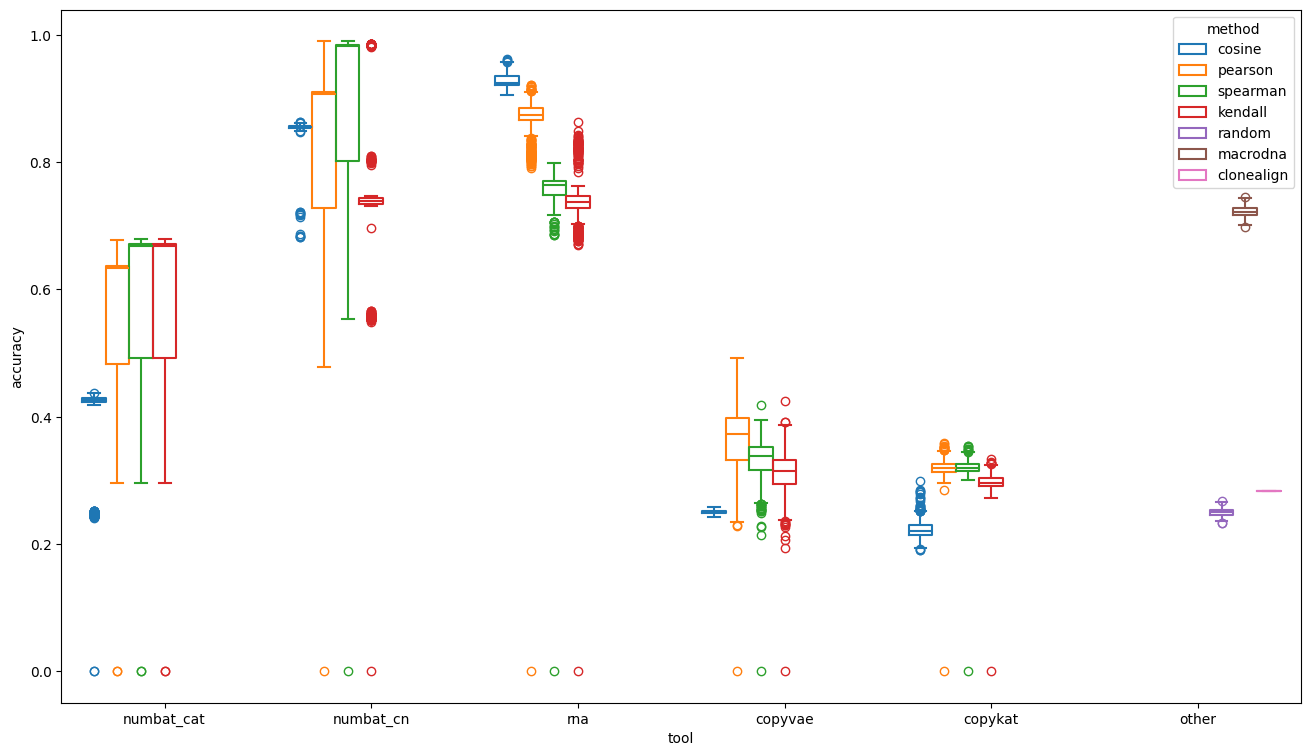

In [ ]:
fig,ax = plt.subplots(figsize=(16,9))
sns.boxplot(stats_df,x="tool",y="accuracy",hue="method",ax=ax,fill=False)
plt.show()

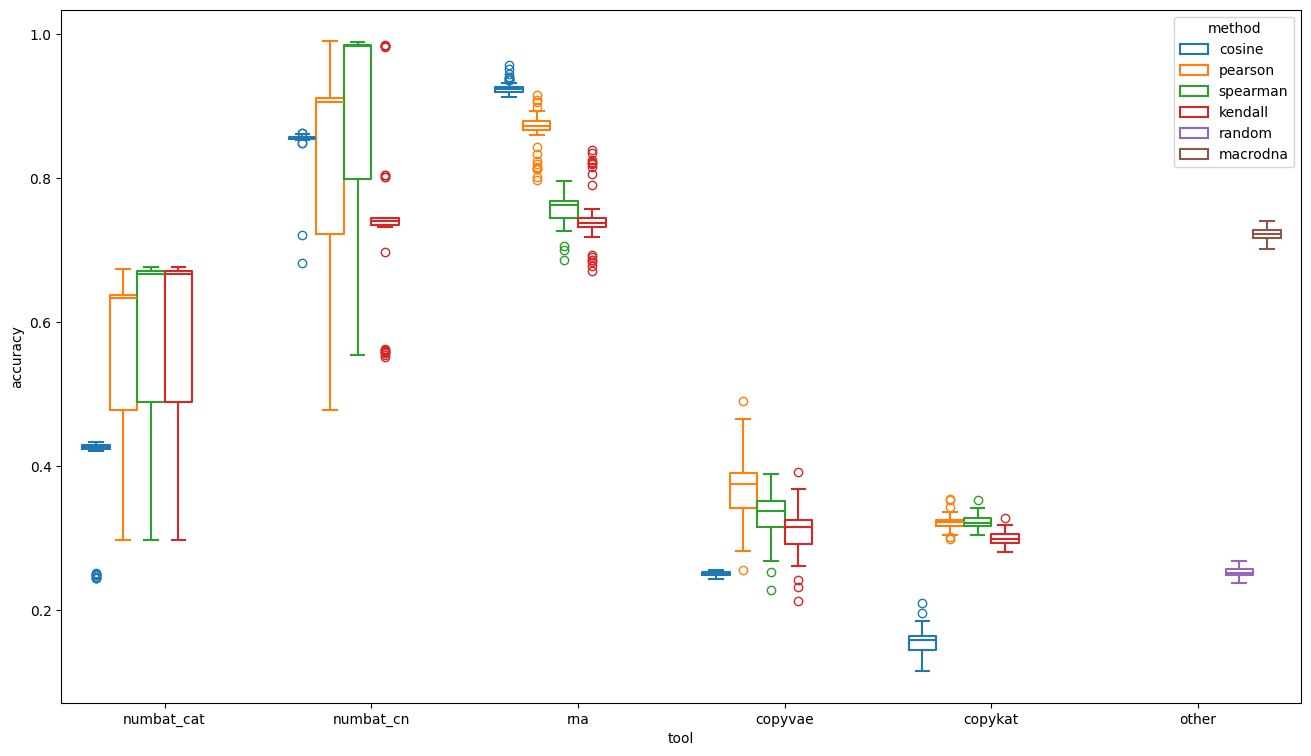

In [12]:
fig,ax = plt.subplots(figsize=(16,9))
sns.boxplot(stats_df,x="tool",y="accuracy",hue="method",ax=ax,fill=False)
plt.show()